In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2584356257085093380
 xla_global_id: -1]

In [14]:
import tensorflow
from tensorflow.keras import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,Dense
from tensorflow.keras.layers import AveragePooling2D,concatenate,GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
'''
# Undersding the Blocks in ResNet
    - Identify Block : Use when input has the same dimention(size) as the output size
    - Convolutional Block : Use when Input and output dimentations does't match up

### Identity Block

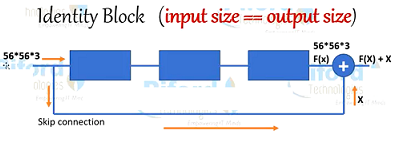

### Convolutional Block

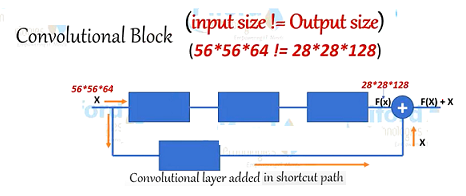

In [8]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.

def identity_block(X, f, filters, stage, block): # Residual Block
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### ResNet50

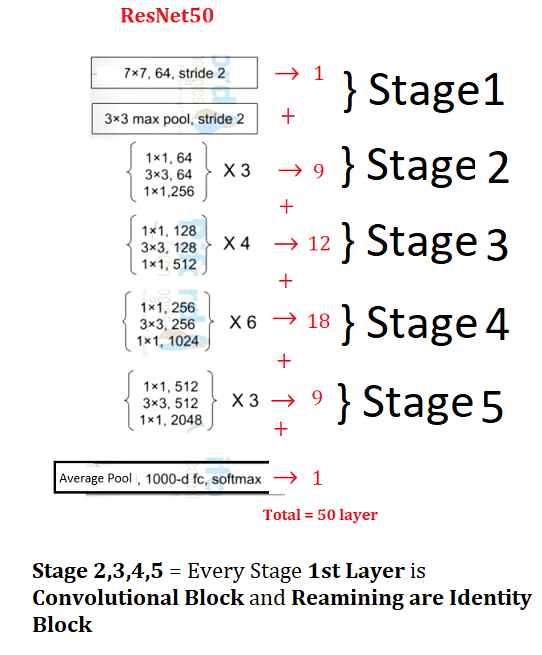

In [ ]:
# Creating ResNet 50

In [12]:
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(64, 64, 3), classes=3):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [15]:
model = ResNet50(input_shape = (64, 64, 3), classes = 3)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
% cd /content/drive/MyDrive/ComputerVision/dataset/ImgClassification

/content/drive/MyDrive/ComputerVision/dataset/ImgClassification


In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')

room_types = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')
print (room_types)  #what kinds of rooms are in this dataset

print("Types of rooms found: ", len(dataset_path))

['bed_room', 'dining_room', 'living_room']
Types of rooms found:  3


In [20]:
rooms = []

for item in room_types:
 # Get all the file names
 all_rooms = os.listdir('rooms_dataset' + '/' +item)
 #print(all_shoes)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('rooms_dataset' + '/' +item) + '/' + room))
    print(rooms)

[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1303451__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/b

In [21]:
# Build a dataframe        
rooms_df = pd.DataFrame(data=rooms, columns=['room type', 'image'])
print(rooms_df.head())

  room type                                              image
0  bed_room  rooms_dataset/bed_room/architecture-modern-hou...
1  bed_room        rooms_dataset/bed_room/bed-1048194__340.jpg
2  bed_room        rooms_dataset/bed_room/bed-1846251__340.jpg
3  bed_room        rooms_dataset/bed_room/bed-1303451__340.jpg
4  bed_room    rooms_dataset/bed_room/bed-4540208__340 (1).jpg


In [22]:
# Let's check how many samples for each category are present
print("Total number of rooms in the dataset: ", len(rooms_df))

room_count = rooms_df['room type'].value_counts()

print("rooms in each category: ")
print(room_count)

Total number of rooms in the dataset:  37
rooms in each category: 
living_room    14
bed_room       12
dining_room    11
Name: room type, dtype: int64


In [25]:
import cv2
path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/'

im_size = 64

images = []
labels = []

for i in room_types:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [26]:
images[0].shape

(64, 64, 3)

In [27]:
images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(37, 64, 64, 3)

In [28]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
y=rooms_df['room type'].values
#print(y[:5])

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [29]:
y=y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder

# binary encode
onehot_encoder = OneHotEncoder(categories='auto',sparse=False)
Y = onehot_encoder.fit_transform(y)

In [30]:
Y.shape

(37, 3)

In [31]:
Y[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(35, 64, 64, 3)
(35, 3)
(2, 64, 64, 3)
(2, 3)


In [34]:
model.fit(train_x, train_y, epochs = 10, batch_size = 32)

Epoch 1/10
2/2 [==============================] - 6s 629ms/step - loss: 1.5768 - accuracy: 0.5429
Epoch 2/10
2/2 [==============================] - 6s 634ms/step - loss: 1.7231 - accuracy: 0.4286
Epoch 3/10
2/2 [==============================] - 5s 637ms/step - loss: 2.6189 - accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 5s 605ms/step - loss: 1.6896 - accuracy: 0.4000
Epoch 5/10
2/2 [==============================] - 5s 613ms/step - loss: 1.1159 - accuracy: 0.6286
Epoch 6/10
2/2 [==============================] - 6s 663ms/step - loss: 1.1630 - accuracy: 0.6571
Epoch 7/10
2/2 [==============================] - 6s 621ms/step - loss: 1.2881 - accuracy: 0.5714
Epoch 8/10
2/2 [==============================] - 6s 618ms/step - loss: 0.9460 - accuracy: 0.5714
Epoch 9/10
2/2 [==============================] - 6s 651ms/step - loss: 2.3756 - accuracy: 0.3714
Epoch 10/10
2/2 [==============================] - 6s 602ms/step - loss: 1.0674 - accuracy: 0.6000


In [35]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))

1/1 [==============================] - 1s 1s/step - loss: 3.6860 - accuracy: 0.0000e+00
Loss = 3.685965061187744


Input image shape: (1, 64, 64, 3)


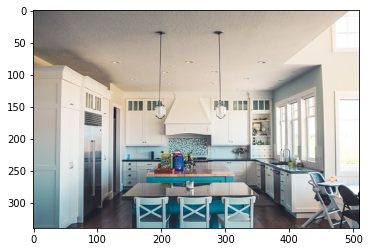

In [38]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

img_path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/dining_room/kitchen-2565105__340.jpg'

img = image.load_img(img_path, target_size=(64, 64))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [39]:
print(model.predict(x))

[[1. 0. 0.]]


In [40]:
import numpy as np
np.argmax(model.predict(x))

0